# Recommendation Systems 4

### Recommendation based on genre (Cosine Similarity)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from ETL import ETL_class

In [4]:
path_rating = './dataset/ratings/'
path_titles = './dataset/titles/'
etl = ETL_class(path_titles, path_rating)

df_movies = etl.get_movies()[['id', 'title', 'listed_in']].rename(columns={'listed_in': 'genre'})
print(df_movies.shape)
df_movies.head()

(22998, 3)


,id,title,genre
0,as1,the grand seduction,"comedy, drama"
1,as2,take care good night,"drama, international"
2,as3,secrets of deception,"action, drama, suspense"
3,as4,pink: staying true,documentary
4,as5,monster maker,"drama, fantasy"


In [3]:
df_ratings = etl.get_ratings()[['userId', 'rating', 'movieId']].rename(columns={'movieId':'id'})
print(df_ratings.shape)
df_ratings.head()

(11024165, 3)


,userId,rating,id
0,1,1.0,as680
1,1,4.5,ns2186
2,1,5.0,hs2381
3,1,5.0,ns3663
4,1,5.0,as9500


In [46]:
genres = [s for g in df_movies.genre.values for s in g.strip( ).split(', ')]
characters = ['&','-','/','and']

for c in characters:
    genres = [g.strip( ) for gr in genres for g in gr.split(c)]

values, counts = np.unique(genres, return_counts=True)
print(len(values), len(counts))

132 132


In [108]:
genres = {ii+1: [v, c] for ii, v, c in zip(range(len(values)), values, counts)}
genres = pd.DataFrame(genres).T.reset_index()
genres.rename(columns={'index': 'genreId', 0: 'genre', 1: 'count'}, inplace=True)
genres.head()

,genreId,genre,count
0,1,,882
1,2,action,3523
2,3,adult animation,37
3,4,adventure,2294
4,5,animals,208


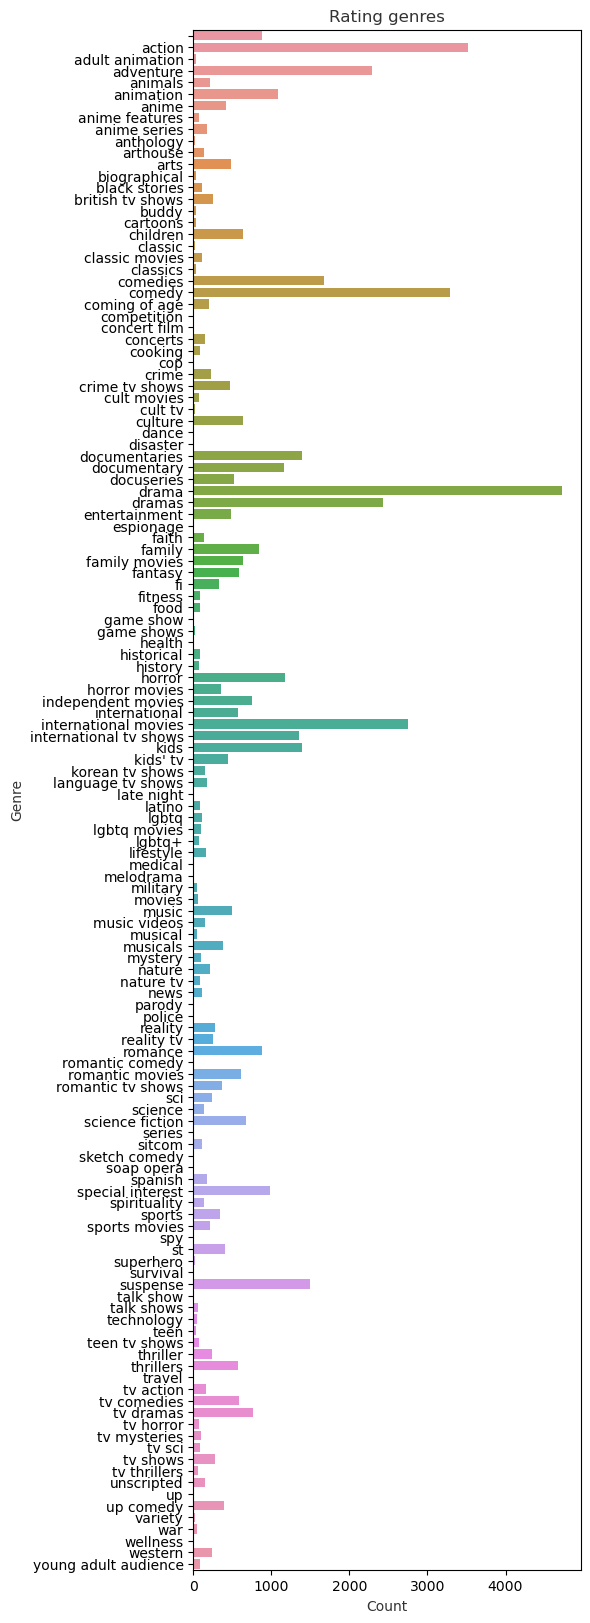

In [109]:
plt.figure(figsize=(5,20))
sns.barplot(x='count', y='genre', data=genres)
plt.title('Rating genres', alpha=0.8)
plt.xlabel('Count', alpha=0.8)
plt.ylabel('Genre', alpha=0.8)
plt.show()

In [110]:
df_count = df_ratings[['userId','id']].groupby('id').count()
df_count.reset_index(inplace=True)
df_count.rename(columns={'userId': 'count'}, inplace=True)
# treshold
df_count = df_count.loc[df_count['count'] >= 500]
df_count.head()

,id,count
0,as1,502
1,as10,513
16,as1012,508
25,as1020,529
28,as1023,502


In [111]:
df = pd.merge(df_movies, df_count, on='id', how='left').dropna()
df = df[['id', 'genre']]
df['genre_list'] = df['genre'].apply(lambda x: x.strip( ).split(', '))

for c in characters:
    L = lambda l: [x.strip( ) for g in l for x in g.split(c)]
    df['genre_list'] = df['genre_list'].apply(L)
    
print(df.shape)
df.head()

(4221, 3)


,id,genre,genre_list
0,as1,"comedy, drama","[comedy, drama]"
6,as7,"documentary, special interest","[documentary, special interest]"
7,as8,comedy,[comedy]
9,as10,drama,[drama]
23,as24,tv shows,[tv shows]


In [112]:
movies_genres = pd.DataFrame(0, index=df['id'].values, columns=genres['genre'].values)#.reset_index()
# movies_genres.rename(columns={'index': 'id'}, inplace=True)
print(movies_genres.shape)
movies_genres.head()

(4221, 132)


,,action,adult animation,adventure,animals,animation,anime,anime features,anime series,anthology,...,tv shows,tv thrillers,unscripted,up,up comedy,variety,war,wellness,western,young adult audience
as1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
as7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
as8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
as10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
as24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
for movie in movies_genres.index:
    gnr = df.loc[df['id'] == movie]['genre_list'].values[0]
    for g in gnr:
        movies_genres.loc[movie,g] = 1

movies_genres.head()

,,action,adult animation,adventure,animals,animation,anime,anime features,anime series,anthology,...,tv shows,tv thrillers,unscripted,up,up comedy,variety,war,wellness,western,young adult audience
as1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
as7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
as8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
as10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
as24,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [136]:
movies_genres.drop(columns=[''], inplace=True)
old_columns = movies_genres.columns
new_columns = np.arange(1,132,1)
movies_genres.rename(columns={o: n for (o, n) in zip(old_columns, new_columns)}, inplace=True)
movies_genres.head()

,1,2,3,4,5,6,7,8,9,10,...,122,123,124,125,126,127,128,129,130,131
as1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
as7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
as8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
as10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
as24,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ns8791,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ns8792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ns8797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ns8799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

movie_genre_matrix = csr_matrix(movies_genres.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_genre_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [155]:
random_index = np.random.choice(movies_genres.shape[0])
print(random_index)
distances, indices = model_knn.kneighbors(movies_genres.iloc[random_index, :].values.reshape(1,-1), n_neighbors=10)

2138


In [156]:
indices = np.append(indices, random_index)
indices = indices[::-1]
indices

array([2138, 2361, 3713, 2041, 2417, 3506, 2359, 2358, 2039, 3857, 2190])

In [162]:
for ii in range(0, len(indices.flatten())):
    if ii == 0:
        idx = movies_genres.index[random_index]
        print('Recomendations for {}:\n'.format(idx))
    else:
        idx = indices.flatten()[ii]
        mox = movies_genres.index[idx]
        dix = distances.flatten()[ii-1]
        print('{}: {}, with discance of {}:'.format(ii, mox, dix))

Recomendations for hs543:

1: hs1796, with discance of 0.0:
2: ns6105, with discance of 0.0:
3: hs53, with discance of 0.0:
4: hs2158, with discance of 0.0:
5: ns5053, with discance of 0.0:
6: hs1783, with discance of 0.0:
7: hs1777, with discance of 0.0:
8: hs44, with discance of 0.0:
9: ns6860, with discance of 0.0:
10: hs842, with discance of 0.0:


In [163]:
recom = {movies_genres.index[k]: v for (k, v) in zip(indices.flatten()[1:], distances.flatten())}
recom

{'hs1796': 0.0,
 'ns6105': 0.0,
 'hs53': 0.0,
 'hs2158': 0.0,
 'ns5053': 0.0,
 'hs1783': 0.0,
 'hs1777': 0.0,
 'hs44': 0.0,
 'ns6860': 0.0,
 'hs842': 0.0}

In [165]:
idx = movies_genres.index[random_index]
df_movies.loc[df_movies['id'] == idx]

,id,title,genre
542,hs543,stray,documentaries


In [166]:
for k in recom.keys():
    print(df_movies.loc[df_movies['id'] == k],'\n')

          id           title          genre
1795  hs1796  after parkland  documentaries 

          id                   title          genre
6104  ns6105  ai weiwei: never sorry  documentaries 

      id    title          genre
52  hs53  jacinta  documentaries 

          id                  title          genre
2157  hs2158  somm: into the bottle  documentaries 

          id                                 title          genre
5052  ns5053  liberated: the new sexual revolution  documentaries 

          id                      title          genre
1782  hs1783  defining moments with ozy  documentaries 

          id                             title          genre
1776  hs1777  the most dangerous animal of all  documentaries 

      id  title          genre
43  hs44  gunda  documentaries 

          id                 title          genre
6859  ns6860  god knows where i am  documentaries 

        id                 title          genre
841  hs842  the black full monty  documentarie